<a href="https://colab.research.google.com/github/Poffix-github/ML_Project_NBA/blob/main/ML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Project

## NBA Match Predictions

### Currently working on adding significant features (so far: elo rating and win percentage, FT percentage, FG percentage, FG3 percentage and Rebounds of the last 10 games of both teams). The plan is to add as much as we can before starting feature selection.

In [6]:
import pandas as pd

In [ ]:
# Load the dataset
df = pd.read_csv("games.csv")
df

FileNotFoundError: ignored

In [8]:
df1 = pd.read_csv("../data/last10g_ELOk32.csv")

In [ ]:
del df["GAME_STATUS_TEXT"] #deleting the most useless column 
df=df.sort_values("GAME_DATE_EST") #we order the games by date in ascending order
df = df.dropna() #let's drop all the rows containing null values
df = df.reset_index(drop=True) #reset the indexes


KeyError: ignored

In [ ]:
# Adding Elo rating of each team for each game (basic version we have to improve, 
# we may want to somehow reset the Elo ratings of each team at the beginning of each new season)

def add_elo_ratings(dataset, team1_column, team2_column):
  # Initialize the Elo rating of each team to 1500
  elo_ratings = {team: 1500 for team in dataset[team1_column]}
  
  # Add new columns for the Elo ratings of each team
  dataset['home_team_elo'] = 0
  dataset['away_team_elo'] = 0
  
  # Iterate through the games and update the Elo ratings
  for index, row in dataset.iterrows():
    team1 = row[team1_column]
    team2 = row[team2_column]
    
    # Add the Elo ratings to the dataset
    dataset.at[index, 'home_team_elo'] = elo_ratings[team1]
    dataset.at[index, 'away_team_elo'] = elo_ratings[team2]
    
    # Calculate the Elo rating for each team using the formula
    team1_rating = elo_ratings[team1]
    team2_rating = elo_ratings[team2]
    
    # Update the Elo ratings based on the outcome of the game
    if row['HOME_TEAM_WINS'] == 1:
      team1_rating, team2_rating = update_elo_ratings(team1_rating, team2_rating)
    else:
      team2_rating, team1_rating = update_elo_ratings(team2_rating, team1_rating)
      
    # Update the Elo ratings in the dictionary
    elo_ratings[team1] = team1_rating
    elo_ratings[team2] = team2_rating
    
  return dataset


def update_elo_ratings(winner_rating, loser_rating):
  # Calculate the expected score for each team
  winner_expected = 1 / (1 + 10 ** ((loser_rating - winner_rating) / 400))
  loser_expected = 1 / (1 + 10 ** ((winner_rating - loser_rating) / 400))
  
  # Calculate the new ratings
  k = 32  # The k-factor determines the weight of the game in the rating system
  winner_rating += k * (1 - winner_expected)
  loser_rating += k * (0 - loser_expected)
  
  return winner_rating, loser_rating
 

In [ ]:
#running the above function on our dataframe
df = add_elo_ratings(df, 'HOME_TEAM_ID', 'VISITOR_TEAM_ID')


In [ ]:
df['elo_difference'] = df['home_team_elo']-df['away_team_elo']



In [ ]:
def calculate_win_pct(df):
  # Create a new column for the home team's win percentage
  df['WIN_PCT_10_home'] = 0.0
  # Create a new column for the away team's win percentage
  df['WIN_PCT_10_away'] = 0.0

  # Iterate over the rows of the dataframe
  for i, row in df.iterrows():
    # Get the home team's ID and the away team's ID
    home_team_id = row['HOME_TEAM_ID']
    away_team_id = row['VISITOR_TEAM_ID']
    game_date = row['GAME_DATE_EST']

    # Find the home team's previous 10 matches
    home_team_prev_matches = df[((df['HOME_TEAM_ID'] == home_team_id) | (df['VISITOR_TEAM_ID'] == home_team_id)) & (df['GAME_DATE_EST'] < game_date)].tail(10)
    # Find the away team's previous 10 matches
    away_team_prev_matches = df[((df['HOME_TEAM_ID'] == away_team_id) | (df['VISITOR_TEAM_ID'] == away_team_id)) & (df['GAME_DATE_EST'] < game_date)].tail(10)

    # Calculate the home team's win percentage in the previous 10 matches, or set it to 0.0 if there are not enough previous matches
    if home_team_prev_matches.shape[0] == 10:
     home_team_win_pct = home_team_prev_matches[((home_team_prev_matches['HOME_TEAM_ID'] == home_team_id) & (home_team_prev_matches['HOME_TEAM_WINS'] == 1)) 
                                              | ((home_team_prev_matches['VISITOR_TEAM_ID'] == home_team_id) & (home_team_prev_matches['HOME_TEAM_WINS'] == 0))].shape[0] / 10
    else:
      home_team_win_pct = 0.0

    # Calculate the away team's win percentage in the previous 10 matches, or set it to 0.0 if there are not enough previous matches
    if away_team_prev_matches.shape[0] == 10:
       away_team_win_pct = away_team_prev_matches[((away_team_prev_matches['HOME_TEAM_ID'] == away_team_id) & (away_team_prev_matches['HOME_TEAM_WINS'] == 1)) 
       | ((away_team_prev_matches['VISITOR_TEAM_ID'] == away_team_id) & (away_team_prev_matches['HOME_TEAM_WINS'] == 0))].shape[0] / 10
    else:
      away_team_win_pct = 0.0

     # Set the win percentage for the home team and the away team in the current row
    df.at[i, 'WIN_PCT_10_home'] = home_team_win_pct
    df.at[i, 'WIN_PCT_10_away'] = away_team_win_pct

  # Return the modified dataframe
  return df


df = calculate_win_pct(df)

In [ ]:
def get_matches_for_team(df, team_id):
  # Filter the dataframe to only include matches played by a specific team
  team_matches = df[(df['HOME_TEAM_ID'] == team_id) | (df['VISITOR_TEAM_ID'] == team_id)]
  # Return the filtered dataframe
  return team_matches

# Example:
team_id = 1610612742
team_matches = get_matches_for_team(df, team_id)

 #checking if win percentage computation works well
team_matches[['HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'HOME_TEAM_WINS', 'WIN_PCT_10_home', 'WIN_PCT_10_away']].head(30)

,HOME_TEAM_ID,VISITOR_TEAM_ID,HOME_TEAM_WINS,WIN_PCT_10_home,WIN_PCT_10_away
0,1610612762,1610612742,1,0.0,0.0
3,1610612742,1610612753,1,0.0,0.0
15,1610612747,1610612742,1,0.0,0.0
28,1610612744,1610612742,0,0.0,0.0
46,1610612742,1610612762,1,0.0,0.0
56,1610612742,1610612748,1,0.0,0.0
68,1610612764,1610612742,1,0.0,0.0
77,1610612761,1610612742,1,0.0,0.0
98,1610612759,1610612742,0,0.0,0.0
113,1610612742,1610612740,1,0.0,0.0


In [ ]:
#our data frame with win percenage and elo rating features added
df

,GAME_DATE_EST,GAME_ID,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,...,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS,home_team_elo,away_team_elo,elo_difference,WIN_PCT_10_home,WIN_PCT_10_away
0,2003-10-05,10300001,1610612762,1610612742,2003,1610612762,90.0,0.457,0.735,0.143,...,0.500,0.250,20.0,38.0,1,1500,1500,0,0.0,0.0
1,2003-10-06,10300002,1610612763,1610612749,2003,1610612763,105.0,0.494,0.618,0.267,...,0.700,0.154,20.0,43.0,1,1500,1500,0,0.0,0.0
2,2003-10-07,10300010,1610612764,1610612752,2003,1610612764,104.0,0.506,0.677,0.455,...,0.852,0.188,19.0,37.0,1,1500,1500,0,0.0,0.0
3,2003-10-07,10300004,1610612742,1610612753,2003,1610612742,99.0,0.488,0.667,0.167,...,0.727,0.350,15.0,34.0,1,1484,1500,-16,0.0,0.0
4,2003-10-07,10300008,1610612756,1610612751,2003,1610612756,79.0,0.333,0.781,0.133,...,0.679,0.250,22.0,47.0,0,1500,1500,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25692,2022-03-12,22101010,1610612762,1610612758,2021,1610612762,134.0,0.558,0.710,0.390,...,0.857,0.394,27.0,33.0,1,1561,1367,194,0.6,0.2
25693,2022-03-12,22101009,1610612743,1610612761,2021,1610612743,115.0,0.551,0.750,0.407,...,0.760,0.387,28.0,50.0,0,1600,1542,58,0.8,0.5
25694,2022-03-12,22101008,1610612744,1610612749,2021,1610612744,122.0,0.484,0.933,0.400,...,0.696,0.386,27.0,39.0,1,1564,1625,-61,0.3,0.7
25695,2022-03-12,22101006,1610612741,1610612739,2021,1610612741,101.0,0.443,0.933,0.429,...,0.824,0.208,19.0,40.0,1,1535,1507,28,0.5,0.3


In [ ]:
def calculate_FG_PCT_average(df):
  # Create a new column 
  df['FG_PCT_avg_10_HOME'] = 0.0
  # Create a new column 
  df['FG_PCT_avg_10_AWAY'] = 0.0

  # Iterate over the rows of the dataframe
  for i, row in df.iterrows():
    # Get the home team's ID and the away team's ID
    home_team_id = row['HOME_TEAM_ID']
    away_team_id = row['VISITOR_TEAM_ID']
    game_date = row['GAME_DATE_EST']

    # Find the home team's previous 10 matches
    home_team_prev_matches = df[((df['HOME_TEAM_ID'] == home_team_id) | (df['VISITOR_TEAM_ID'] == home_team_id)) & (df['GAME_DATE_EST'] < game_date)].tail(10)
    # Find the away team's previous 10 matches
    away_team_prev_matches = df[((df['HOME_TEAM_ID'] == away_team_id) | (df['VISITOR_TEAM_ID'] == away_team_id)) & (df['GAME_DATE_EST'] < game_date)].tail(10)

    # Calculate the home team's FG_PCT average in the previous 10 matches, or set it to 0.0 if there are not enough previous matches
    if home_team_prev_matches.shape[0] == 10:
     home_team_FG_pctsum1 = home_team_prev_matches[home_team_prev_matches['HOME_TEAM_ID'] == home_team_id]['FG_PCT_home'].sum()
     home_team_FG_pctsum2 = home_team_prev_matches[home_team_prev_matches['VISITOR_TEAM_ID'] == home_team_id]['FG_PCT_away'].sum()
     home_team_FG_pct_avg =  (home_team_FG_pctsum1 + home_team_FG_pctsum2) / 10
    else:
      home_team_FG_pct_avg = 0.0

    # Calculate the away team's FG_PCT average in the previous 10 matches, or set it to 0.0 if there are not enough previous matches
    if away_team_prev_matches.shape[0] == 10:
       away_team_FG_pctsum1 = away_team_prev_matches[away_team_prev_matches['HOME_TEAM_ID'] == away_team_id]['FG_PCT_home'].sum()
       away_team_FG_pctsum2 = away_team_prev_matches[away_team_prev_matches['VISITOR_TEAM_ID'] == away_team_id]['FG_PCT_away'].sum()
       away_team_FG_pct_avg =  (away_team_FG_pctsum1 + away_team_FG_pctsum2) / 10
       
    else:
      away_team_FG_pct_avg = 0.0

     # Set the FG_PCT average for the home team and the away team in the current row
    df.at[i, 'FG_PCT_avg_10_HOME'] = home_team_FG_pct_avg
    df.at[i, 'FG_PCT_avg_10_AWAY'] = away_team_FG_pct_avg

  # Return the modified dataframe
  return df

In [ ]:
calculate_FG_PCT_average(df)

,GAME_DATE_EST,GAME_ID,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,...,WIN_PCT_10_home,WIN_PCT_10_away,FG_PCT_avg_10_HOME,FG_PCT_avg_10_AWAY,FT_PCT_avg_10_HOME,FT_PCT_avg_10_AWAY,FG3_PCT_avg_10_HOME,FG3_PCT_avg_10_AWAY,REB_avg_10_HOME,REB_avg_10_AWAY
0,2003-10-05,10300001,1610612762,1610612742,2003,1610612762,90.0,0.457,0.735,0.143,...,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0
1,2003-10-06,10300002,1610612763,1610612749,2003,1610612763,105.0,0.494,0.618,0.267,...,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0
2,2003-10-07,10300010,1610612764,1610612752,2003,1610612764,104.0,0.506,0.677,0.455,...,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0
3,2003-10-07,10300004,1610612742,1610612753,2003,1610612742,99.0,0.488,0.667,0.167,...,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0
4,2003-10-07,10300008,1610612756,1610612751,2003,1610612756,79.0,0.333,0.781,0.133,...,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25692,2022-03-12,22101010,1610612762,1610612758,2021,1610612762,134.0,0.558,0.710,0.390,...,0.6,0.2,0.4729,0.4622,0.7560,0.7625,0.3778,0.3189,48.0,41.4
25693,2022-03-12,22101009,1610612743,1610612761,2021,1610612743,115.0,0.551,0.750,0.407,...,0.8,0.5,0.4896,0.4421,0.8089,0.7398,0.3268,0.3320,46.3,45.6
25694,2022-03-12,22101008,1610612744,1610612749,2021,1610612744,122.0,0.484,0.933,0.400,...,0.3,0.7,0.4875,0.4903,0.7322,0.7724,0.3702,0.3825,41.1,49.2
25695,2022-03-12,22101006,1610612741,1610612739,2021,1610612741,101.0,0.443,0.933,0.429,...,0.5,0.3,0.4932,0.4741,0.8121,0.8076,0.3554,0.3378,43.2,41.9


In [ ]:
team_matches = get_matches_for_team(df, team_id)

 #checking if everything works fine
team_matches[['HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'FG_PCT_home', 'FG_PCT_away', 'FG_PCT_avg_10_HOME', 'FG_PCT_avg_10_AWAY',  ]].tail(30)

,HOME_TEAM_ID,VISITOR_TEAM_ID,FG_PCT_home,FG_PCT_away,FG_PCT_avg_10_HOME,FG_PCT_avg_10_AWAY
25247,1610612742,1610612744,0.379,0.407,0.4614,0.4802
25260,1610612745,1610612742,0.425,0.544,0.4623,0.4595
25277,1610612742,1610612741,0.500,0.433,0.4700,0.4917
25299,1610612752,1610612742,0.467,0.410,0.4299,0.4712
25315,1610612763,1610612742,0.382,0.516,0.4715,0.4715
25318,1610612742,1610612753,0.410,0.481,0.4804,0.4329
25341,1610612742,1610612760,0.398,0.434,0.4643,0.4244
25357,1610612742,1610612761,0.487,0.385,0.4572,0.4286
25360,1610612742,1610612756,0.435,0.453,0.4540,0.4738
25383,1610612742,1610612763,0.486,0.374,0.4528,0.4673


In [ ]:
#Let's add other features with the same procedure

def calculate_stats(df):
  
  df['FT_PCT_avg_10_HOME'] = 0.0
  df['FT_PCT_avg_10_AWAY'] = 0.0
  df['FG3_PCT_avg_10_HOME'] = 0.0
  df['FG3_PCT_avg_10_AWAY'] = 0.0
  df['REB_avg_10_HOME'] = 0.0
  df['REB_avg_10_AWAY'] = 0.0
  # Iterate over the rows of the dataframe
  for i, row in df.iterrows():
    # Get the home team's ID and the away team's ID
    home_team_id = row['HOME_TEAM_ID']
    away_team_id = row['VISITOR_TEAM_ID']
    game_date = row['GAME_DATE_EST']

    # Find the home team's previous 10 matches
    home_team_prev_matches = df[((df['HOME_TEAM_ID'] == home_team_id) | (df['VISITOR_TEAM_ID'] == home_team_id)) & (df['GAME_DATE_EST'] < game_date)].tail(10)
    # Find the away team's previous 10 matches
    away_team_prev_matches = df[((df['HOME_TEAM_ID'] == away_team_id) | (df['VISITOR_TEAM_ID'] == away_team_id)) & (df['GAME_DATE_EST'] < game_date)].tail(10)

    # Calculate the home team's FG_PCT average in the previous 10 matches, or set it to 0.0 if there are not enough previous matches
    if home_team_prev_matches.shape[0] == 10:
     home_team_FT_pctsum1 = home_team_prev_matches[home_team_prev_matches['HOME_TEAM_ID'] == home_team_id]['FT_PCT_home'].sum()
     home_team_FT_pctsum2 = home_team_prev_matches[home_team_prev_matches['VISITOR_TEAM_ID'] == home_team_id]['FT_PCT_away'].sum()
     home_team_FT_pct_avg =  (home_team_FT_pctsum1 + home_team_FT_pctsum2) / 10
     home_team_FG3_pctsum1 = home_team_prev_matches[home_team_prev_matches['HOME_TEAM_ID'] == home_team_id]['FG3_PCT_home'].sum()
     home_team_FG3_pctsum2 = home_team_prev_matches[home_team_prev_matches['VISITOR_TEAM_ID'] == home_team_id]['FG3_PCT_away'].sum()
     home_team_FG3_pct_avg =  (home_team_FG3_pctsum1 + home_team_FG3_pctsum2) / 10
     home_team_REB_sum1 = home_team_prev_matches[home_team_prev_matches['HOME_TEAM_ID'] == home_team_id]['REB_home'].sum()
     home_team_REB_sum2 = home_team_prev_matches[home_team_prev_matches['VISITOR_TEAM_ID'] == home_team_id]['REB_away'].sum()
     home_team_REB_avg =  (home_team_REB_sum1 + home_team_REB_sum2) / 10
    else:
      home_team_FT_pct_avg = 0.0
      home_team_FG3_pct_avg = 0.0
      home_team_REB_avg = 0.0
    # Calculate the away team's FG_PCT average in the previous 10 matches, or set it to 0.0 if there are not enough previous matches
    if away_team_prev_matches.shape[0] == 10:
       away_team_FT_pctsum1 = away_team_prev_matches[away_team_prev_matches['HOME_TEAM_ID'] == away_team_id]['FT_PCT_home'].sum()
       away_team_FT_pctsum2 = away_team_prev_matches[away_team_prev_matches['VISITOR_TEAM_ID'] == away_team_id]['FT_PCT_away'].sum()
       away_team_FT_pct_avg =  (away_team_FT_pctsum1 + away_team_FT_pctsum2) / 10
       away_team_FG3_pctsum1 = away_team_prev_matches[away_team_prev_matches['HOME_TEAM_ID'] == away_team_id]['FG3_PCT_home'].sum()
       away_team_FG3_pctsum2 = away_team_prev_matches[away_team_prev_matches['VISITOR_TEAM_ID'] == away_team_id]['FG3_PCT_away'].sum()
       away_team_FG3_pct_avg =  (away_team_FG3_pctsum1 + away_team_FG3_pctsum2) / 10
       away_team_REB_sum1 = away_team_prev_matches[away_team_prev_matches['HOME_TEAM_ID'] == away_team_id]['REB_home'].sum()
       away_team_REB_sum2 = away_team_prev_matches[away_team_prev_matches['VISITOR_TEAM_ID'] == away_team_id]['REB_away'].sum()
       away_team_REB_avg =  (away_team_REB_sum1 + away_team_REB_sum2) / 10
    else:
      away_team_FT_pct_avg = 0.0
      away_team_FG3_pct_avg = 0.0
      away_team_REB_avg = 0.0
     # Set the FG_PCT average for the home team and the away team in the current row
    df.at[i, 'FT_PCT_avg_10_HOME'] = home_team_FT_pct_avg
    df.at[i, 'FT_PCT_avg_10_AWAY'] = away_team_FT_pct_avg
    df.at[i, 'FG3_PCT_avg_10_HOME'] = home_team_FG3_pct_avg
    df.at[i, 'FG3_PCT_avg_10_AWAY'] = away_team_FG3_pct_avg
    df.at[i, 'REB_avg_10_HOME'] = home_team_REB_avg
    df.at[i, 'REB_avg_10_AWAY'] = away_team_REB_avg

  # Return the modified dataframe
  return df

In [ ]:
calculate_stats(df)

,GAME_DATE_EST,GAME_ID,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,...,WIN_PCT_10_home,WIN_PCT_10_away,FG_PCT_avg_10_HOME,FG_PCT_avg_10_AWAY,FT_PCT_avg_10_HOME,FT_PCT_avg_10_AWAY,FG3_PCT_avg_10_HOME,FG3_PCT_avg_10_AWAY,REB_avg_10_HOME,REB_avg_10_AWAY
0,2003-10-05,10300001,1610612762,1610612742,2003,1610612762,90.0,0.457,0.735,0.143,...,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0
1,2003-10-06,10300002,1610612763,1610612749,2003,1610612763,105.0,0.494,0.618,0.267,...,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0
2,2003-10-07,10300010,1610612764,1610612752,2003,1610612764,104.0,0.506,0.677,0.455,...,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0
3,2003-10-07,10300004,1610612742,1610612753,2003,1610612742,99.0,0.488,0.667,0.167,...,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0
4,2003-10-07,10300008,1610612756,1610612751,2003,1610612756,79.0,0.333,0.781,0.133,...,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25692,2022-03-12,22101010,1610612762,1610612758,2021,1610612762,134.0,0.558,0.710,0.390,...,0.6,0.2,0.0,0.0,0.7560,0.7625,0.3778,0.3189,48.0,41.4
25693,2022-03-12,22101009,1610612743,1610612761,2021,1610612743,115.0,0.551,0.750,0.407,...,0.8,0.5,0.0,0.0,0.8089,0.7398,0.3268,0.3320,46.3,45.6
25694,2022-03-12,22101008,1610612744,1610612749,2021,1610612744,122.0,0.484,0.933,0.400,...,0.3,0.7,0.0,0.0,0.7322,0.7724,0.3702,0.3825,41.1,49.2
25695,2022-03-12,22101006,1610612741,1610612739,2021,1610612741,101.0,0.443,0.933,0.429,...,0.5,0.3,0.0,0.0,0.8121,0.8076,0.3554,0.3378,43.2,41.9


In [ ]:
df1 = df[df['GAME_DATE_EST']>'2003-12-31'][['HOME_TEAM_ID', 'VISITOR_TEAM_ID','elo_difference', 'WIN_PCT_10_home','WIN_PCT_10_away', 'FG_PCT_avg_10_HOME', 'FG_PCT_avg_10_AWAY', 'FT_PCT_avg_10_HOME', 'FT_PCT_avg_10_AWAY', 'FG3_PCT_avg_10_HOME', 'FG3_PCT_avg_10_AWAY', 'REB_avg_10_HOME', 'REB_avg_10_AWAY', 'HOME_TEAM_WINS']].reset_index(drop=True)
df1[['elo_difference', 'WIN_PCT_10_home','WIN_PCT_10_away', 'FG_PCT_avg_10_HOME', 'FG_PCT_avg_10_AWAY', 'FT_PCT_avg_10_HOME', 'FT_PCT_avg_10_AWAY', 
    'FG3_PCT_avg_10_HOME', 'FG3_PCT_avg_10_AWAY', 'REB_avg_10_HOME', 'REB_avg_10_AWAY']]

,elo_difference,WIN_PCT_10_home,WIN_PCT_10_away,FG_PCT_avg_10_HOME,FG_PCT_avg_10_AWAY,FT_PCT_avg_10_HOME,FT_PCT_avg_10_AWAY,FG3_PCT_avg_10_HOME,FG3_PCT_avg_10_AWAY,REB_avg_10_HOME,REB_avg_10_AWAY
0,258,0.8,0.2,0.5148,0.4394,0.7587,0.7351,0.3544,0.2750,40.6,42.9
1,-135,0.1,0.4,0.4067,0.4420,0.7705,0.7130,0.2760,0.3007,41.9,41.9
2,121,0.7,0.4,0.4714,0.3849,0.7877,0.7442,0.3743,0.2890,42.8,45.6
3,110,0.5,0.4,0.4314,0.4443,0.7464,0.7519,0.3003,0.3014,40.1,38.2
4,87,0.6,0.5,0.4174,0.4256,0.7805,0.7748,0.3674,0.3434,39.6,44.4
...,...,...,...,...,...,...,...,...,...,...,...
25227,194,0.6,0.2,0.4729,0.4622,0.7560,0.7625,0.3778,0.3189,48.0,41.4
25228,58,0.8,0.5,0.4896,0.4421,0.8089,0.7398,0.3268,0.3320,46.3,45.6
25229,-61,0.3,0.7,0.4875,0.4903,0.7322,0.7724,0.3702,0.3825,41.1,49.2
25230,28,0.5,0.3,0.4932,0.4741,0.8121,0.8076,0.3554,0.3378,43.2,41.9


In [5]:
# Feature importance for selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
X = df1[['elo_difference', 'WIN_PCT_10_home','WIN_PCT_10_away', 'FG_PCT_avg_10_HOME', 'FG_PCT_avg_10_AWAY', 'FT_PCT_avg_10_HOME', 'FT_PCT_avg_10_AWAY', 
        'FG3_PCT_avg_10_HOME', 'FG3_PCT_avg_10_AWAY', 'REB_avg_10_HOME', 'REB_avg_10_AWAY']]
y = df1['HOME_TEAM_WINS']
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a random forest classifier on the training data
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

# Get the feature importances
importances = clf.feature_importances_

# Sort the feature importances in descending order
sorted_importances = sorted(importances, reverse=True)

# Print the feature names and importances
for feature, importance in zip(X.columns, sorted_importances):
    print(f"{feature}: {importance:.2f}")


elo_difference: 0.18
WIN_PCT_10_home: 0.10
WIN_PCT_10_away: 0.09
FG_PCT_avg_10_HOME: 0.09
FG_PCT_avg_10_AWAY: 0.09
FT_PCT_avg_10_HOME: 0.09
FT_PCT_avg_10_AWAY: 0.09
FG3_PCT_avg_10_HOME: 0.09
FG3_PCT_avg_10_AWAY: 0.08
REB_avg_10_HOME: 0.05
REB_avg_10_AWAY: 0.04


In [12]:
#Feature Scaling
features = ['elo_difference', 'WIN_PCT_10_home','WIN_PCT_10_away', 'FG_PCT_avg_10_HOME', 
            'FG_PCT_avg_10_AWAY', 'FT_PCT_avg_10_HOME', 
            'FT_PCT_avg_10_AWAY', 'FG3_PCT_avg_10_HOME', 'FG3_PCT_avg_10_AWAY', 'REB_avg_10_HOME', 'REB_avg_10_AWAY']
from sklearn.preprocessing import StandardScaler

# Separate the features and the target
X = df1[features]
y = df1['HOME_TEAM_WINS']

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler to the features
scaler.fit(X)

# Transform the features using the scaler
X_scaled = scaler.transform(X)

In [13]:
#First try: getting 64% accuracy (upper bound is 70%)

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create the Random Forest model
model = RandomForestClassifier(n_estimators=100)

# Fit the model to the training data
model.fit(X_train, y_train)

# Evaluate the model on the test data
accuracy = model.score(X_test, y_test)
print("Accuracy:", accuracy)


Accuracy: 0.6439468991480087


In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
model = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(model, X_scaled, y, cv=10)
print("Accuracy:", scores.mean())

Accuracy: 0.6423597671627054


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

#Create the Logistic Regression
model2 = LogisticRegression()

#Perform 10-fold cross validation
scores2 = cross_val_score(model2, X_scaled, y, cv=10)

#Print the average accuracy
print("Accuracy:", scores2.mean())

Accuracy: 0.6587277553638067


In [20]:
# hyper-parameter tuning 
# Author: Raghav RV <rvraghav93@gmail.com>
# License: BSD

import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

# The scorers can be either one of the predefined metric strings or a scorer
# callable, like the one returned by make_scorer
scoring = {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score)}

# Setting refit='AUC', refits an estimator on the whole dataset with the
# parameter setting that has the best cross-validated AUC score.
# That estimator is made available at ``gs.best_estimator_`` along with
# parameters like ``gs.best_score_``, ``gs.best_params_`` and
# ``gs.best_index_``
gs = GridSearchCV(
    LogisticRegression(),
    param_grid={"penalty": [None, 'l2']},
    scoring=scoring,
    refit="AUC",
    n_jobs=2,
    return_train_score=True,
)
gs.fit(X, y)
results = gs.cv_results_

In [26]:
results

{'mean_fit_time': array([0.14659872, 0.14380641]),
 'std_fit_time': array([0.02342763, 0.04950886]),
 'mean_score_time': array([0.00879235, 0.00819554]),
 'std_score_time': array([0.00117329, 0.00214225]),
 'param_penalty': masked_array(data=[None, 'l2'],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'penalty': None}, {'penalty': 'l2'}],
 'split0_test_AUC': array([0.67835674, 0.67840053]),
 'split1_test_AUC': array([0.72700333, 0.72604972]),
 'split2_test_AUC': array([0.69444359, 0.69343922]),
 'split3_test_AUC': array([0.698648  , 0.69912286]),
 'split4_test_AUC': array([0.67829215, 0.67704879]),
 'mean_test_AUC': array([0.69534876, 0.69481222]),
 'std_test_AUC': array([0.01785146, 0.01778275]),
 'rank_test_AUC': array([1, 2]),
 'split0_train_AUC': array([0.70013341, 0.7001315 ]),
 'split1_train_AUC': array([0.68761655, 0.68863884]),
 'split2_train_AUC': array([0.6970194 , 0.69608655]),
 'split3_train_AUC': array([0.69515327, 0.695

ValueError: could not convert string to float: 'l2'

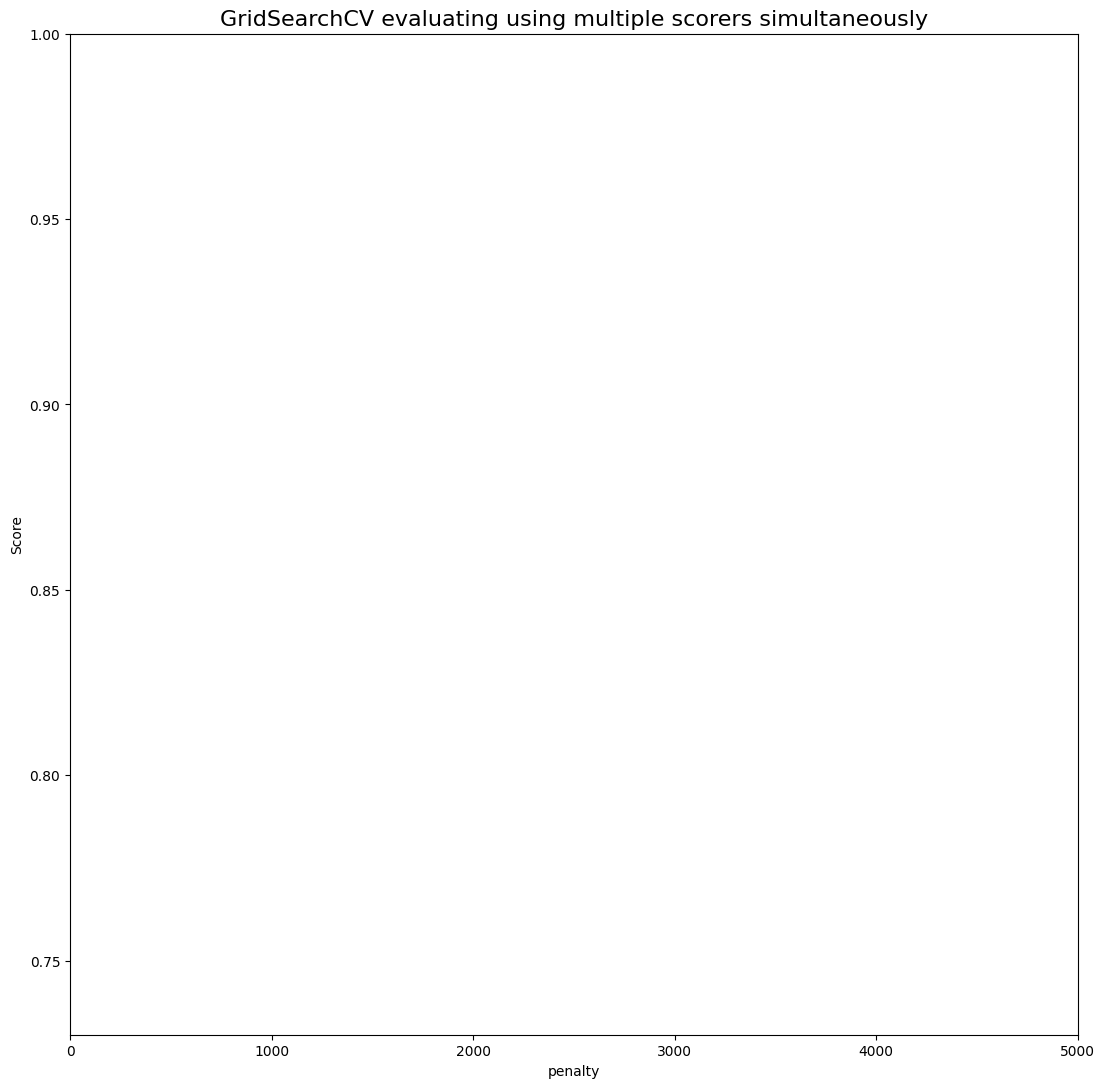

In [22]:
plt.figure(figsize=(13, 13))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously", fontsize=16)

plt.xlabel("penalty")
plt.ylabel("Score")

ax = plt.gca()
ax.set_xlim(0, 5000)
ax.set_ylim(0.73, 1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results["param_penalty"].data, dtype=float)

for scorer, color in zip(sorted(scoring), ["g", "k"]):
    for sample, style in (("train", "--"), ("test", "-")):
        sample_score_mean = results["mean_%s_%s" % (sample, scorer)]
        sample_score_std = results["std_%s_%s" % (sample, scorer)]
        ax.fill_between(
            X_axis,
            sample_score_mean - sample_score_std,
            sample_score_mean + sample_score_std,
            alpha=0.1 if sample == "test" else 0,
            color=color,
        )
        ax.plot(
            X_axis,
            sample_score_mean,
            style,
            color=color,
            alpha=1 if sample == "test" else 0.7,
            label="%s (%s)" % (scorer, sample),
        )

    best_index = np.nonzero(results["rank_test_%s" % scorer] == 1)[0][0]
    best_score = results["mean_test_%s" % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot(
        [
            X_axis[best_index],
        ]
        * 2,
        [0, best_score],
        linestyle="-.",
        color=color,
        marker="x",
        markeredgewidth=3,
        ms=8,
    )

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.show()

In [15]:
scores2

array([0.65174326, 0.64698891, 0.68093539, 0.68212446, 0.6646849 ,
       0.65398335, 0.67776457, 0.64169639, 0.65120888, 0.63614744])

In [16]:
count_of_ones = df1['HOME_TEAM_WINS'].sum()
total_rows = df1.shape[0]
dummy_classifier_accuracy = count_of_ones/total_rows

print("Dummy classifier accuracy:", dummy_classifier_accuracy)

Dummy classifier accuracy: 0.5890535827520609


ModuleNotFoundError: ignored